# <font color='#B31B1'> Decision Trees </font>

One of the most popular algorithms for classification and regression are decision trees. The underlying idea is simple - we're going to build a set of rules in tree-form to classify a data point. For example, a simple decision tree to predict if you're falling asleep in class could be IF coffee_consumption == 0 THEN asleep_in_class = TRUE ELSE False. They're particularly popular because they're interpretable. (You can see a tree and know exactly how it maps from an input to a decision.)

In [21]:
from IPython.display import Image
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(6,6)}) 

## <font color='#B31B1'> Titanic Dataset </font>

We are going to use the [Titanic dataset](https://www.kaggle.com/c/titanic/data) for this example. We'll load it directly from the seaborn plotting package.

This dataset appears in one of the most basic and popular kaggle competitions: https://www.kaggle.com/c/titanic

In [22]:
data = sns.load_dataset('titanic').drop(['alive'], axis = 1) #Removing some 'cheating' columns
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,True


We process the dataset

In [3]:
#We're going to convert our categorical data into 1-Hot Columns 
#What this does is turns our cateogrical feature data into dummy variables.
# have a read of this article - https://www.pluralsight.com/guides/handling-categorical-data-in-machine-learning-models
passengers = pd.get_dummies(data)

#Fill in NA values for age with the average
passengers.age = passengers.age.fillna(passengers.age.mean())

#Drop any rows with other misssing valules
passengers = passengers.dropna()

passengers

,survived,pclass,age,sibsp,parch,fare,adult_male,alone,sex_female,sex_male,...,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton
0,0,3,22.000000,1,0,7.2500,True,False,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,1,38.000000,1,0,71.2833,False,False,1,0,...,0,0,1,0,0,0,0,1,0,0
2,1,3,26.000000,0,0,7.9250,False,True,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,35.000000,1,0,53.1000,False,False,1,0,...,0,0,1,0,0,0,0,0,0,1
4,0,3,35.000000,0,0,8.0500,True,True,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.000000,0,0,13.0000,True,True,0,1,...,0,0,0,0,0,0,0,0,0,1
887,1,1,19.000000,0,0,30.0000,False,True,1,0,...,0,1,0,0,0,0,0,0,0,1
888,0,3,29.699118,1,2,23.4500,False,False,1,0,...,0,0,0,0,0,0,0,0,0,1
889,1,1,26.000000,0,0,30.0000,True,True,0,1,...,0,0,1,0,0,0,0,1,0,0


In [4]:
label = "survived"
features = passengers.drop(columns=label).columns

## <font color='#B31B1'> Decision Trees 'Manually' </font>
To get some intution for the decision tree algorithm, let's try to find an optimal root-node split for our dataset ourselves. For simplicity, consider a smaller version of our dataset with 2 features: age and gender.

In [5]:
X = passengers[['age','sex_male','survived']]
X.head()

,age,sex_male,survived
0,22.0,1,0
1,38.0,0,1
2,26.0,0,1
3,35.0,0,1
4,35.0,1,0


We first have to pick which measure of node purity we want to use - let's use Gini (but try implementing your own cross-entropy function for fun!).

In [6]:
def gini(data, feature, split):
    
    left_node = data[data[feature] > split]
    p_left = left_node.survived.mean()
    N_left = left_node.shape[0]/data.shape[0]
    
    right_node = data[data[feature] <= split]
    p_right = right_node.survived.mean()

    
    return N_left*p_left*(1-p_left) + (1-N_left)*p_right*(1-p_right)

In [23]:
best_impurity = np.Inf
best_split = None

for feature in ['age','sex_male']: # search over features
    for s in X[feature].unique():  # search over thresholds
        impurity = gini(passengers,feature,s)

        if impurity < best_impurity:
            best_impurity = impurity
            best_split = s
            best_split_feature = feature
        
print('Our best split is ', best_split_feature, '>', best_split)

Our best split is  sex_male > 0


We can investigate if our split led to a big change in node purity...

In [24]:
passengers.survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: survived, dtype: float64

In [25]:
passengers.query('sex_male > 0').survived.value_counts(normalize=True)

0    0.811092
1    0.188908
Name: survived, dtype: float64

In [26]:
passengers.query('sex_male <= 0').survived.value_counts(normalize=True)

1    0.742038
0    0.257962
Name: survived, dtype: float64

In [11]:
passengers.sex_male.value_counts()

1    577
0    314
Name: sex_male, dtype: int64

Seems like gender is a good split for determining survival rate! We could repeat this process for two new nodes, one with all the male data, one for all the female and so on and so forth...

## <font color='#B31B1'> Decision Trees in Scikit-Learn </font>

Like most machine learning algorithms, the exceedingly smart people at scikit-learn have implemented decision trees in an optimized version of python called cython. In scikit-learn the tree based algorithms are in the `sklearn.tree` submodule.

Scikit-learn tree implementation [uses an optimized version of CART](http://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) *(Classification and Regression Trees)*, that allows us to use the decision trees for both classification and regression.

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

tree = DecisionTreeClassifier()

In [28]:
tree.fit(passengers[features], passengers.survived)

X = passengers[features]
Y = passengers.survived

tree.fit(X, Y)

DecisionTreeClassifier()

In [29]:
tree.predict(passengers[features])[:10]

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1])

Instead of doing one train-test split of our data, we can use **cross-validation** to get an 'average' performance over k splits of our dataset. Scikit-learn does that automaticaly for us using the `cross_val_score` function. Here 'cv' is the parameter to indicate the number of splits. We can even specify what error metric we want to look at (i.e. accuracy vs. AUC)

In [32]:
cross_val_score(tree, X, Y,
                scoring="accuracy", 
                cv=5).mean()

0.7755821982298663

One very good advantage that decision trees have is that they can be visualized, and we can explain why they take a certain decision  (we say trees have a high **explainability**). Scikit-learn trees can be visualized with `Graphviz`, a graph visualization tool. You can install it using `conda install -c anaconda graphviz` followed by `conda install python-graphviz`.

If we have installed graphviz we can plot the tree directly.

In [42]:
import graphviz
from sklearn.tree import export_graphviz

def draw_tree(tree):
    dot_data = export_graphviz(tree, out_file=None, 
                         feature_names=features, 
                               class_names=['survived', 'died'],
                         filled=True, 
                         #impurity=True,
                         rounded=True,  
                         special_characters=True,
                              proportion = True)  #trying changing proportion = False
    
    graph = graphviz.Source(dot_data)
    graph.format = 'png'
    graph.render('tree',view=True)

In [43]:
draw_tree(tree)

In [35]:
#We can always check out the help docs
DecisionTreeClassifier?

These are the most important hyperparameters for scikit-learn `DecisionTreeClassifier`:

Here is a great article that goes over how to understand and potentially use these for tuning your model ... 
https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680


* **criterion** : The partition criterion to use, we can use either `gini`, or `entropy` 

* **max_depth** (int>1) : The max depth the tree can achieve. We define as depth as the number of nodes an observation goes through (how many *questions* are asked).

* **max_features** (int or float(percentage)):  The maximum number of potential partitions evaluated when we split a node.

* **max_leaf_nodes** (int or None): Max number of leaves in the tree.

* **min_impurity_decrease** (float) : The minimum information gain required in a node to split it (if no feature provides that minimum, the node becomes a leaf).

* **class_weight** : For imbalanced classes, we can use `class_weight`, which is a dictionary with the shape `{class: weight}`, so sklearn takes the class weights into consideration. We can also use `class_weight=balanced` so sklearn creates the weights automatically based on class distribution.

Decision trees are prone to overfitting, there are some hyperparameters that help us control this:

* **min_samples_leaf** (int or float(percentage)) : Minimum number of observations on a node to consider the node a leaf. Default value is 1, this means that by default sklearn will create leaves with one observation (and this memorize the dataset).

* **min_samples_split** (int or float(percentage)) : Minimum number of observations on a node to generate a partition. By default is 2, this means sklearn will split all nodes with 2 or more observations by default.

For example, we can create a simpler tree by setting the maximum depth

In [44]:
simple_tree = DecisionTreeClassifier(max_depth=4)

In [45]:
simple_tree.fit(passengers.drop("survived", axis=1), 
                 passengers.survived)

DecisionTreeClassifier(max_depth=4)

In [46]:
draw_tree(simple_tree)

In [39]:
cross_val_score(simple_tree, passengers.drop("survived", axis=1), 
                passengers.survived, scoring="roc_auc", cv=3).mean()

0.8452928770012463

So we see this simple tree performs much better than the initial tree (that was overfitting), and it is also very simple to explain!

But how do we know what the optimal depth is?

Well this is a balance of practicality and "hyperparameter tuning" ... 

In [40]:
# Perhaps for our business problem anything with greater than depth of 10 is too complicated and don't want to run the risk of overfitting (think of our first tree...)
# So let's test a range of depths from 2:10 using a for loop

depths = np.arange(2,10) # define the depths
results = [] # create an empty data frame for our results

for depth in depths:
    best_depth_tree = DecisionTreeClassifier(max_depth = depth) # creating an instance of a decision tree
    results.append(cross_val_score(best_depth_tree, passengers.drop("survived", axis=1), 
                                   passengers.survived, scoring="roc_auc", # getting the cv accuracy metric for the tree at each depth
                cv=3).mean())



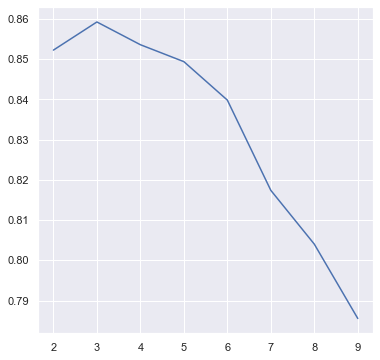

In [41]:
test = pd.DataFrame({'depths':depths, 'mean_roc_auc':results})
test.sort_values("mean_roc_auc", ascending=False)
plt.plot(test.depths, test.mean_roc_auc)

So I would now move forward with my model with max_depth set = 3